In [29]:
%matplotlib inline

import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [212]:
import re
from os import listdir
from os.path import isfile, join
def plot_loss_vs_step(raw_path,ending='.out',save_path=False):
    files = [join(raw_path,f) for f in listdir(raw_path) if (isfile(join(raw_path, f)) and ending in f)]
    loss_arrays = [get_losses(open(f).read()) for f in files]
    node_counts = np.array([get_num_gpus(open(f).read()) for f in files])
    for (i,loss_arr) in enumerate(loss_arrays):
        plt.semilogy(np.array(range(len(loss_arr)))*node_counts[i],loss_arr,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
    plt.legend(loc=(1,0))
    if save_path:
        plt.savefig(save_path)

def get_from_csv(f):
    dat = np.genfromtxt(f,delimiter=',',names=True)
    epochs = dat['epoch']
    train_loss = dat['train_loss']
    val_loss = dat['val_loss']
    val_roc = dat['val_roc']
    return epochs,train_loss,val_loss,val_roc

#regexes for parsing the log files
def get_num_gpus(text):
    p = re.compile('\[batch = \d+ = \d+\*\d+\]')
    matches = p.findall(text)
    nums = re.findall(r'\d+',matches[0])
    return int(nums[-1])

def get_sync_percentages(text):
    p = re.compile('\[\d+.\d% calc., \d+.\d% synch.\]')
    matches = p.findall(text)[1:]
    nums = [float(re.findall(r'\d+.\d',match)[-1]) for match in matches]
    return np.mean(nums)/100
    
def get_loss(text):
    #p = re.compile('loss: \d+\.\d+ ')
    p = re.compile('loss: \d+\.\d+ \[\d+\.\d+\]')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return nums[-1]

def get_effective_epoch(text):
    p = re.compile(' \[\d+.\d+\/\d+\]')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[0]) for match in matches]
    return nums

def get_effective_epoch_and_loss(text):
    p = re.compile(' \[\d+.\d+\/\d+\], ' + 'loss: \d+\.\d+ \[\d+\.\d+\]')
    matches = p.findall(text)
    e_eff = [float(re.findall(r'\d+.\d+',match)[0]) for match in matches]
    e_eff = np.linspace(0,e_eff[-1],len(e_eff))
    loss = np.array([float(re.findall(r'\d+.\d+',match)[-1]) for match in matches])
    return e_eff,loss


    
def get_epoch_size(text):
    p = re.compile(' \[\d+.\d+\/\d+\]')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[0]) for match in matches]
    epoch_size = float(re.findall(r'\d+.\d+',matches[0])[1])
    return epoch_size
    

def get_losses(text):
    p = re.compile('loss: \d+\.\d+ \[\d+\.\d+\]')
    #'loss: \d+\.\d+ \[\d+\.\d+\]'
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return np.array(nums)


#     return int(nums[-1])

def get_execution_time(text):
    p = re.compile('Epoch \d+.\d+ finished \(\d+.\d+ epochs passed\) in \d+.\d+ seconds')
    #p = re.compile('Epoch 2 finished in \d+.\d+ seconds')
    match = p.findall(text)[1]
    execution_time = float(re.findall(r'\d+\.\d',match)[-1])
    effective_epochs_passed = float(re.findall(r'\d+\.\d',match)[-2])
    return execution_time/effective_epochs_passed


def relative_array(arr):
    return arr/arr[0]

## Plot from CSV log files

In [249]:
#only works if in the same order as the GPU counts!
csvfiles = [join(raw_path,f) for f in listdir(raw_path) if (isfile(join(raw_path, f)) and 'callback' in f)]
csvfiles = list(zip(*sorted(zip(node_counts,csvfiles)))[1])
f = csvfiles[0]


by_epoch_stats = [get_from_csv(f) for f in csvfiles]

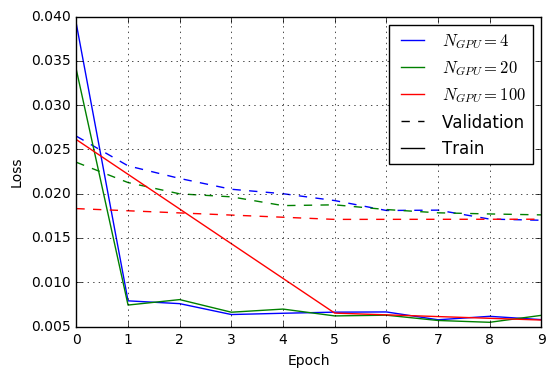

In [251]:
colors = ['b','g','r']

for (i,loss_arr) in enumerate(loss_arrays):
    by_epoch = by_epoch_stats[i]
    epoch,t_loss,val_loss,val_roc = by_epoch
    alpha = 1.0
    if node_counts[i] == 4:
        alpha = 0.4
#     plt.semilogy(effective_epochs[i],np.array(range(len(loss_arr)))*node_counts[i],loss_arr,alpha=alpha,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
    plt.plot(epoch,t_loss,color=colors[i],label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
    plt.plot(epoch,val_loss,'--',color=colors[i])

    
plt.plot([],[],'--k',label="Validation")
plt.plot([],[],'-k',label="Train")
plt.xlim([0,9])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid()

## Plot from CSV log files

In [246]:
a = effective_epochs_and_loss[0][1]
a
import pandas as pd
def get_rolling_mean(arr,N):
    ret = np.zeros_like(arr)
    cutoff=N-1
    for i in range(cutoff):
        ret[i] = np.mean(arr[:i])
#     ret[:cutoff] = arr[:cutoff]
    ret[cutoff:] = pd.rolling_mean(arr,N)[cutoff:]
    return ret


/Users/julian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


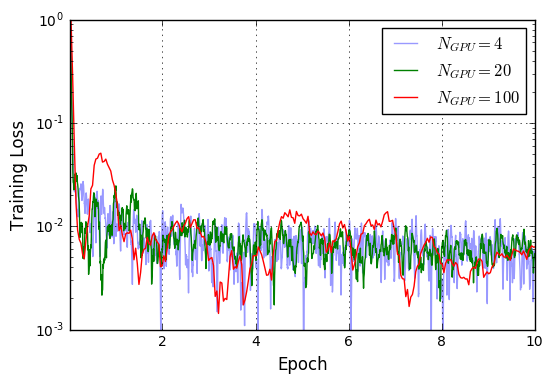

In [250]:
for (i,loss_arr) in enumerate(loss_arrays):
    alpha = 1.0
    to_plot = effective_epochs_and_loss[i][1]
    if node_counts[i] == 4:
        to_plot = get_rolling_mean(to_plot,15) #very noisy
        alpha = 0.4
#     plt.semilogy(effective_epochs[i],np.array(range(len(loss_arr)))*node_counts[i],loss_arr,alpha=alpha,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
    plt.semilogy(effective_epochs_and_loss[i][0]/(epoch_lengths[i]),to_plot,alpha=alpha,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.legend(loc="best")#(1,0))
plt.xlim([1e-2,10])
plt.ylim([1e-3,1])
plt.grid()
plt.xlabel("Epoch",size=12)
plt.ylabel("Training Loss",size=12)

In [152]:
raw_path = '../../plots/'#'./newtest/'
data_size = 'out' #full' #'Titan' #full, large, medium
from os import listdir
from os.path import isfile, join
files = [join(raw_path,f) for f in listdir(raw_path) if (isfile(join(raw_path, f)) and data_size in f)]

In [213]:
import re
node_counts = [get_num_gpus(open(f).read()) for f in files]
print node_counts
files = list(zip(*sorted(zip(node_counts,files)))[1])
files
effective_epochs_and_loss =[get_effective_epoch_and_loss(open(f).read()) for f in files]
epoch_lengths = np.array([get_epoch_size(open(f).read()) for f in files])
node_counts = np.array([get_num_gpus(open(f).read()) for f in files])
sync_percentages =np.array([get_sync_percentages(open(f).read()) for f in files] )
execution_times =np.array([get_execution_time(open(f).read()) for f in files])
# execution_times = [1.0]
losses = np.array([get_loss(open(f).read()) for f in files])
loss_arrays = [get_losses(open(f).read()) for f in files]

[4, 20, 100]


In [75]:
communication_work = sync_percentages/(1-sync_percentages)
scaled_execution_times = execution_times*node_counts
fictitious_node_counts = np.logspace(np.log10(2),np.log10(5000),100)
communication_work_extended = communication_work[-1]/np.log(node_counts[-1])*np.log(fictitious_node_counts)
#communication_work_extended_titan = 0.25*communication_work[-1]/np.log(node_counts[-1])*np.log(fictitious_node_counts)
modeled_execution_times = execution_times[0]*node_counts[0]/fictitious_node_counts*(1 + communication_work_extended)
#modeled_execution_times_titan = execution_times[0]*node_counts[0]/fictitious_node_counts*(1 + communication_work_extended_titan)
scaled_modeled_execution_times = fictitious_node_counts*modeled_execution_times


In [135]:
epoch_lengths

array([ 2899.,  2899.,  2899.])

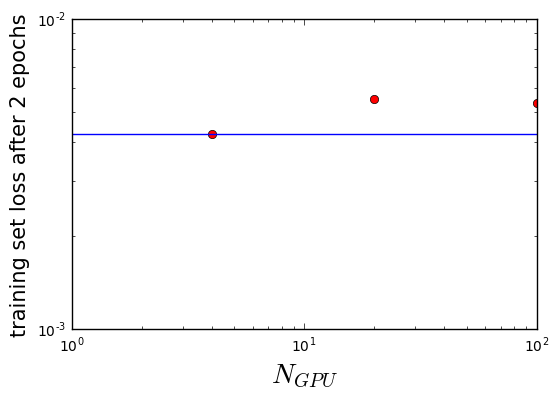

In [78]:
for (i,loss_arr) in enumerate(loss_arrays):
    plt.loglog(node_counts[i],loss_arr[-1],"or")#,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.axhline(loss_arrays[0][-1])
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"training set loss after 2 epochs",size=15)
# plt.legend(loc=(1,0))

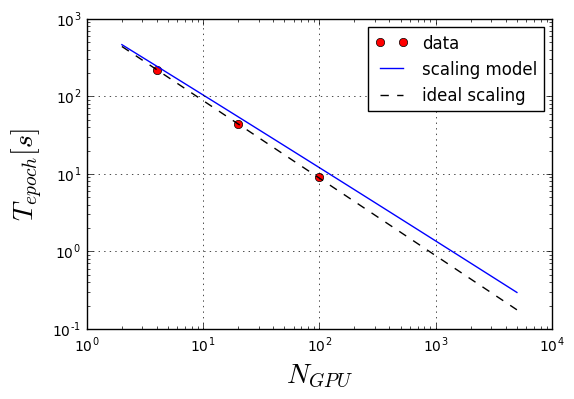

In [79]:
plt.loglog(node_counts,execution_times,'or',label="data")
plt.loglog(fictitious_node_counts,modeled_execution_times,label="scaling model")
#plt.loglog(fictitious_node_counts,modeled_execution_times_titan,label="scaling model 2")
plt.loglog(fictitious_node_counts,execution_times[0]*node_counts[0]/fictitious_node_counts,'--k',label="ideal scaling")
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{epoch} [s]$",size=20)
plt.grid()
plt.legend(loc="best")

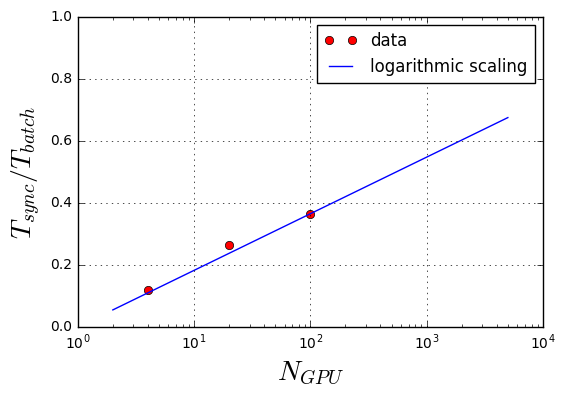

In [80]:
#logarithmic scaling of communication work!
# plt.semilogx(node_counts,communication_work/relative_array(np.log(node_counts)),'ro')
# plt.semilogx(fictitious_node_counts,communication_work_extended/relative_array(np.log(fictitious_node_counts)),'-')
plt.semilogx(node_counts,communication_work,'ro',label='data')
plt.semilogx(fictitious_node_counts,communication_work_extended,'-',label="logarithmic scaling")
#plt.semilogx(fictitious_node_counts,communication_work_extended_titan,'-',label="logarithmic scaling 2")
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{sync}/T_{batch}$",size=20)
plt.ylim([0,1])
plt.legend(loc="best")

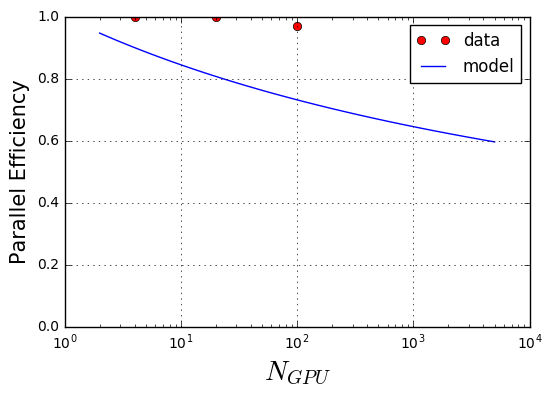

In [81]:
plt.semilogx(node_counts,scaled_execution_times[0]/scaled_execution_times,'ro',label="data")
plt.semilogx(fictitious_node_counts,scaled_execution_times[0]/scaled_modeled_execution_times,'-',label="model")
plt.ylim([0,1])
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"Parallel Efficiency",size=15)
plt.legend(loc="best")

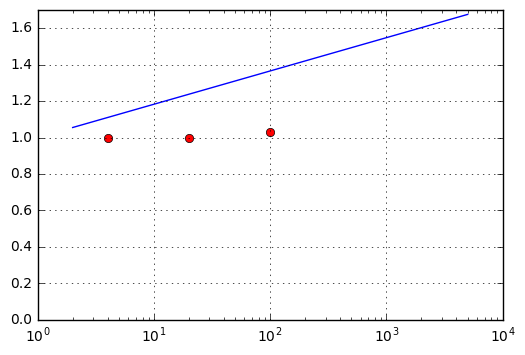

In [82]:
plt.semilogx(node_counts,scaled_execution_times/scaled_execution_times[0],'ro')
plt.semilogx(fictitious_node_counts,scaled_modeled_execution_times/scaled_execution_times[0],'-')
plt.ylim(0)
plt.grid()